## Final Project Submission

Please fill out:
* Student name: Aaron Bastian
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Joe Comeaux

In [52]:
import pandas as pd # data analysis and cleaning
import numpy as np # mathmatical functions + nan values
import matplotlib.pyplot as plt # visualizations
import statsmodels.api as sm # linear regression
import scipy.stats as stats

### PREPARING AT THE DATA

I'll import the dataset and convert the ordinal string variables to integers to allow for early correlation screening.

In [53]:
data = pd.read_csv("/Users/aaronbastian/Documents/Jupyter/Phase2Project/data/kc_house_data.csv").dropna()
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819


In [54]:
data.grade = data.grade.apply(lambda x: int(x.split()[0]))
data.waterfront = data.waterfront.map({"NO": 0, "YES": 1})

conditons = {'Average' : 2, 'Very Good' : 4, 'Good' : 3, 'Poor' : 0, 'Fair': 1}
data.condition = data.condition.map(conditons)

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,NONE,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,NONE,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,NONE,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0,NONE,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0,NONE,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819


<AxesSubplot:>

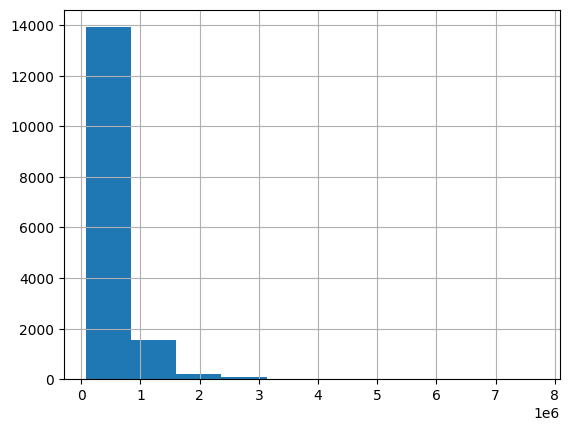

In [55]:
y = data.price
y.hist()

As price is heavily skewed, I will remove outliers.

<AxesSubplot:>

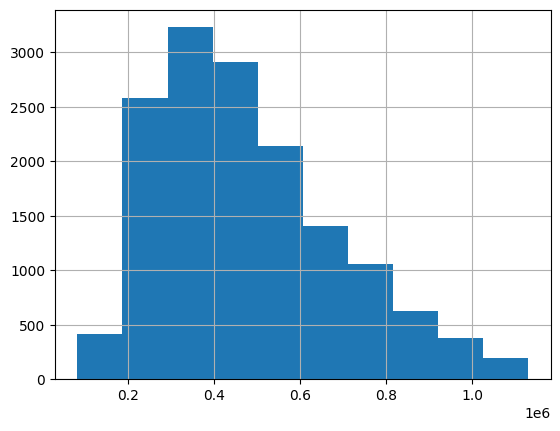

In [56]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

y = remove_outlier_IQR(y)
y.hist()

Thats better.

In [57]:
corrs = data.loc[y.index].corrwith(y)
strong_corrs = corrs[corrs > 0.4]
strong_corrs

price            1.000000
bathrooms        0.453918
sqft_living      0.624003
grade            0.633239
sqft_above       0.534376
lat              0.435178
sqft_living15    0.561940
dtype: float64

### IDENTIFYING INTERACTIONS

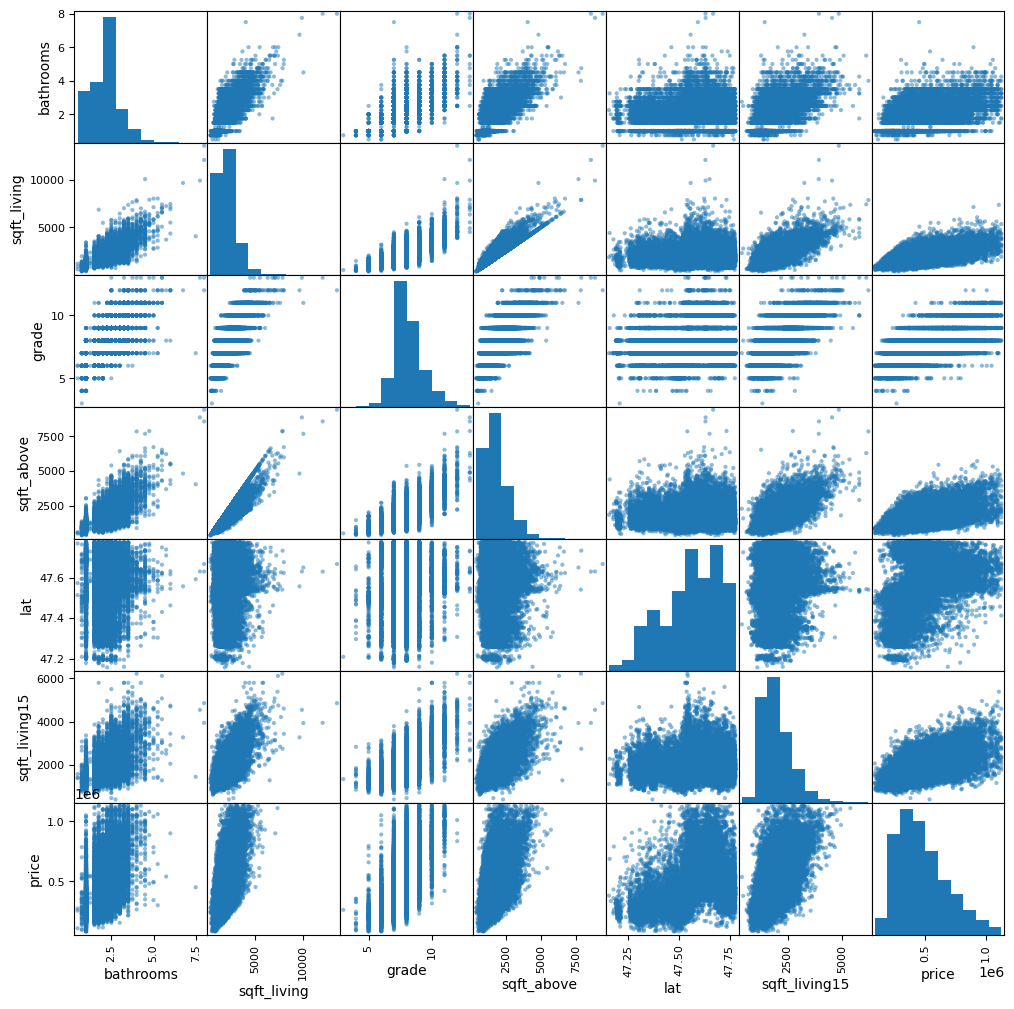

In [58]:
# get the data associated with those columns
X = data[strong_corrs.index].drop("price", axis=1)

pd.plotting.scatter_matrix(pd.concat([X,y], axis=1), figsize=(12, 12))
plt.show()

There appears to be a strong relationship between `sqft_above` and `sqft_living`.  This makes sens of course, as they include eachother in their calculations.  To avoid issues of colinearity, it makes sense to only include `sqft_living` then, as it has the strongest correlation with price.  It also seems that all of the predictors have a similarly skewed distribution as the price except for grade.  Grade is defined by The [King County Assessor website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#g) as corresponding to the quality of contruction and materials and thus the cost of construction.

In [59]:
X.drop(columns=["sqft_above"], inplace=True)

In [60]:
categoricals = ["waterfront", "view"]
dummies = pd.get_dummies(data[categoricals], columns=categoricals ,prefix=categoricals, prefix_sep="_" , dtype=np.int64)
dummies.drop(columns=["waterfront_0", "view_NONE"], inplace=True)

X = pd.concat([X, dummies], axis=1).loc[y.index] # ensure that the target and predictors are aligned with loc[]

In [61]:
# Making a simple function to display relevant model metrics
def evaluate_results(res, target:str="target") -> None:

    # Tests for linearity
    fig_pr, ax_pr = plt.subplots(figsize=(10, 10))
    sm.graphics.plot_partregress_grid(res, fig=fig_pr)
    rainbow = sm.stats.diagnostic.linear_rainbow(res) # linear rainbow test to confirm relationship is linear

    # Tests for heteroskedasticity
    fig, ax = plt.subplots()
    ax.scatter(y, res.resid, alpha = 0.3)
    ax.set_xlabel(target)
    ax.set_ylabel("residuals")
    ax.set_title("Heteroscedastic Residual Plot")
    breusch = sm.stats.diagnostic.het_breuschpagan(res.resid, sm.add_constant(X))

    # Test for normal distribution of residuals
    sm.graphics.qqplot(res.resid, dist=stats.norm, line='45', fit=True)

    plt.show()

    print(res.summary())
    print("\nRMSE:", res.mse_resid ** 0.5, "\n")
    print(f"with a Rainbow Test pvalue of {round(rainbow[1], 3)}, we {'can' if rainbow[1] < 0.05 else 'cannot'} assume the relationship is linear")
    print(f"with a Breusch-Pagan Test pvalue of {round(breusch[1], 3)}, we {'can' if breusch[1] < 0.05 else 'cannot'} assume homoscedasticity")

### BASELINE MODEL

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


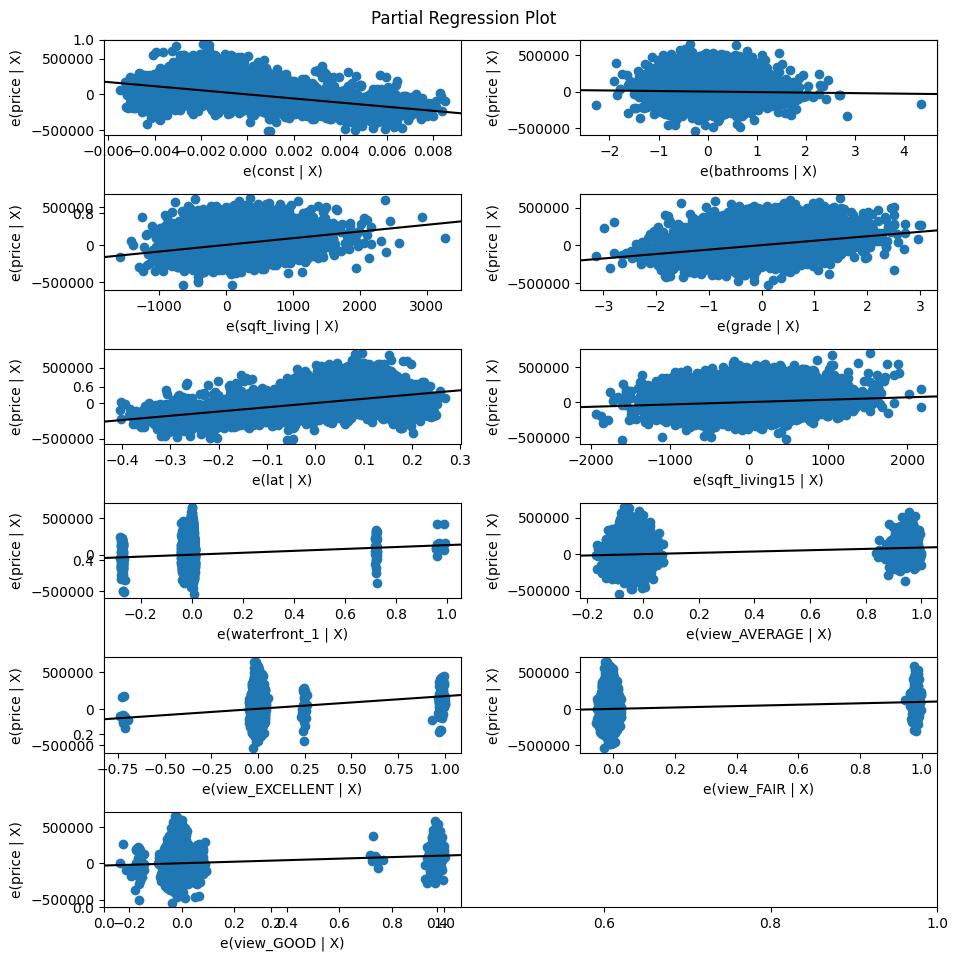

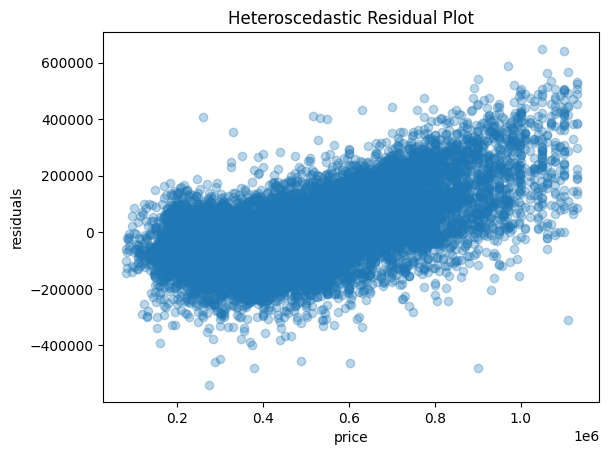

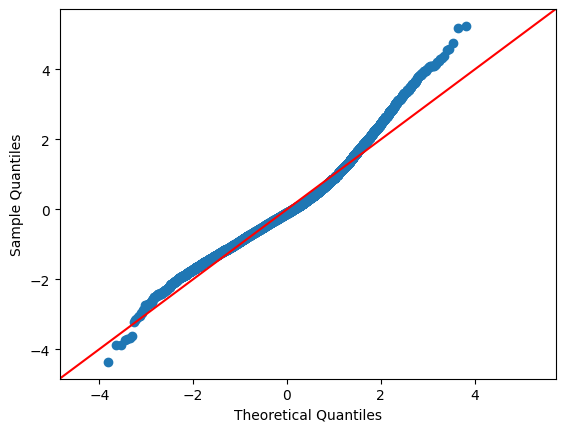

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     2750.
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:40:12   Log-Likelihood:            -1.9625e+05
No. Observations:               14931   AIC:                         3.925e+05
Df Residuals:                   14920   BIC:                         3.926e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.866e+07   3.43e+05    -83.

In [62]:
results = sm.OLS(y, sm.add_constant(X)).fit()
evaluate_results(results, "price")

#### Interpretation
The baseline model performed decently well, statistically signifficantly explaining about 65% of the variance in sale price.  With all else set to 0, the model predicts a house would cost \$-28,664,160.9652.

All of the predictors were statistically significant:    
For each additional bathroom, there is a \$-7263.03 change in price  
For each additional sqft_living, there is a \$+89.07 change in price  
For each additional sqft_living15, there is a \$+33.78 change in price  
For each additional lat, there is a \$+598492.93 change in price  
For each additional grade, there is a \$+59058.73 change in price   
Houses on a waterfront have a \$131,255.15 higher price tag compared to those not on a waterfront  
Houses with a "fair" view have a \$95,636.39 higher price tag than those with "no view"  
Houses with a "average" view have a \$90,037.47 higher price tag than those with "no view"  
Houses with a "good" view have a \$105,346.57 higher price tag than those with "no view"  
Houses with a "excellent" view have a \$173,596.66 higher price tag than those with "no view"  

It is odd that an increase in bathrooms supposedly decreases the price, so I will investigate that.

Although the assumptions of Indepencance, Normality, and Homoscedasticity (equal variances of the residuals/errors) hold in this model, Linearity does not.

In [63]:
# bathrooms x bedrooms
# sqft_living and living15

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


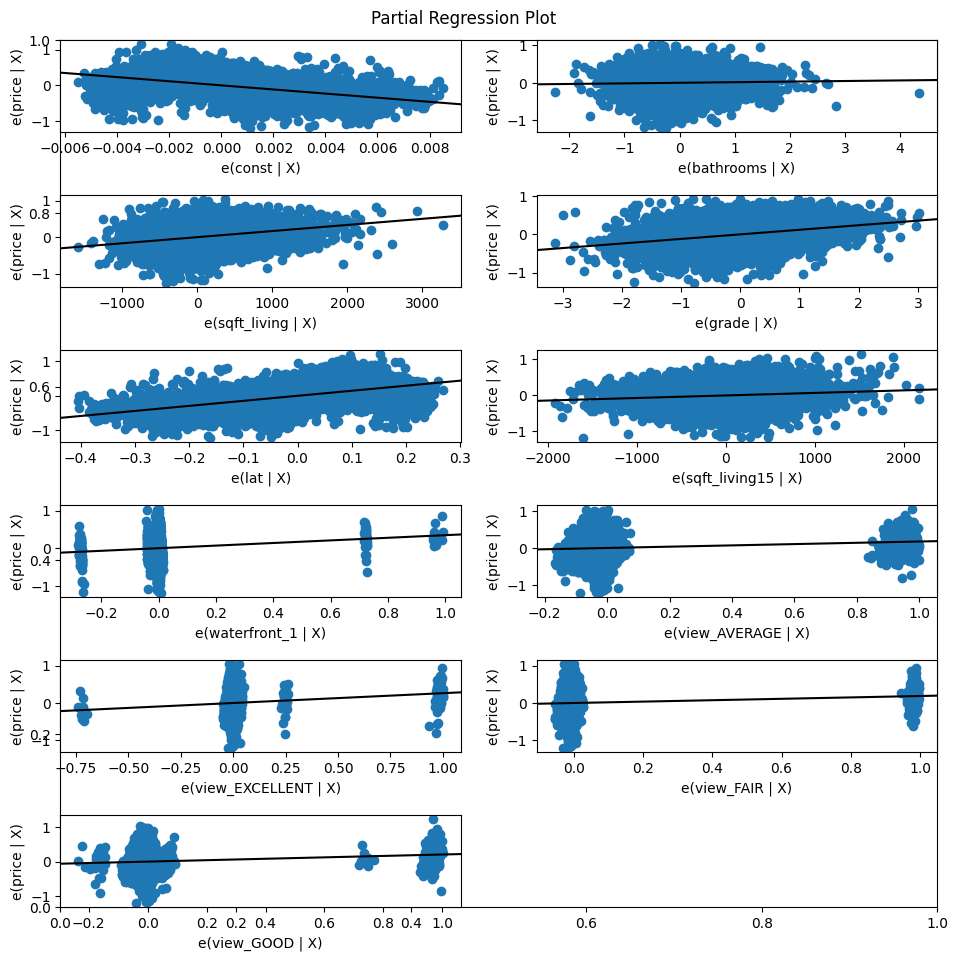

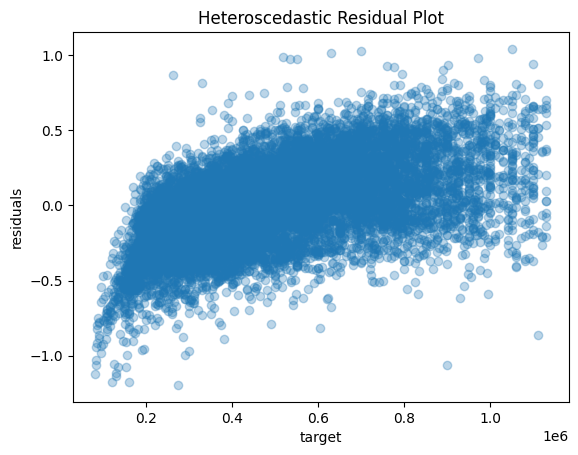

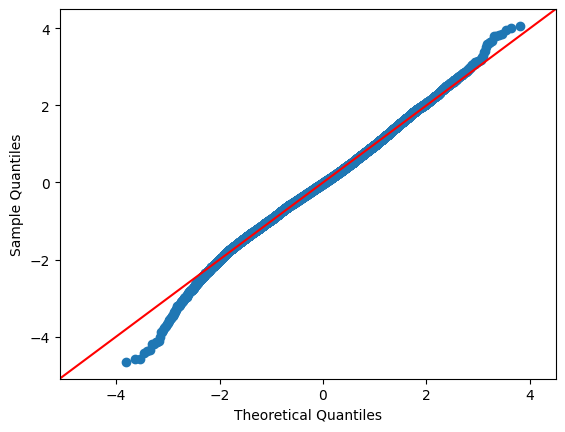

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     2999.
Date:                Wed, 09 Nov 2022   Prob (F-statistic):               0.00
Time:                        11:40:14   Log-Likelihood:                -863.55
No. Observations:               14931   AIC:                             1749.
Df Residuals:                   14920   BIC:                             1833.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -57.6450      0.712    -80.

In [65]:
results_2 = sm.OLS(np.log(y), sm.add_constant(X)).fit()
evaluate_results(results_2)